In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
image_size = 64
latent_size = 128
batch_size = 128
epochs = 200
lr = 0.0002

In [4]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

In [5]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

In [6]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0

In [7]:
generator = build_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        1048576   
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097152   
 ranspose)                                                       
                                                      

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [13]:
import os
import shutil

def move_images(source_dir, target_dir, limit=3000):
    # Check if target directory exists, if not, create it
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Counter for the number of moved images
    moved_count = 0

    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Check if the file is an image (you can add more extensions if needed)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                # Construct full file path
                file_path = os.path.join(root, file)
                
                # Construct the path where the image will be moved
                target_path = os.path.join(target_dir, file)
                
                # Move the image
                shutil.copy(file_path, target_path)
                print(f"Moved: {file_path} -> {target_path}")
                
                # Increment the counter
                moved_count += 1
                
                # Stop after moving the first 'limit' images
                if moved_count >= limit:
                    print(f"Reached the limit of {limit} images.")
                    return

# Set the source directory and the target directory
source_directory = "/kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square"  # Replace with the actual path
target_directory = "/kaggle/working/allimages"  # Replace with the target folder path

# Move the first 3000 images
move_images(source_directory, target_directory, limit=10000)

Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Nike/7525639.191707.jpg -> /kaggle/working/allimages/7525639.191707.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Nike/7525639.151.jpg -> /kaggle/working/allimages/7525639.151.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Teva Kids/7592562.275.jpg -> /kaggle/working/allimages/7592562.275.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Keen Kids/7501314.4535.jpg -> /kaggle/working/allimages/7501314.4535.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Keen Kids/7397030.4535.jpg -> /kaggle/working/allimages/7397030.4535.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut

In [14]:
data_dir = '/kaggle/working/allimages'

In [15]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    image_size=(image_size, image_size), 
    batch_size=batch_size, 
    label_mode=None
)
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

Found 10000 files belonging to 1 classes.


Epoch 1/200...
Epoch 1 completed in 13.49s
Average Generator Loss: 12.8116, Average Discriminator Loss: 0.2415

Epoch 2/200...
Epoch 2 completed in 4.98s
Average Generator Loss: 6.2725, Average Discriminator Loss: 0.8887

Epoch 3/200...
Epoch 3 completed in 4.95s
Average Generator Loss: 3.4526, Average Discriminator Loss: 0.6009

Epoch 4/200...
Epoch 4 completed in 4.95s
Average Generator Loss: 2.9610, Average Discriminator Loss: 0.7592

Epoch 5/200...
Epoch 5 completed in 4.95s
Average Generator Loss: 2.8887, Average Discriminator Loss: 0.5939

Epoch 6/200...
Epoch 6 completed in 4.94s
Average Generator Loss: 2.7908, Average Discriminator Loss: 0.6715

Epoch 7/200...
Epoch 7 completed in 4.95s
Average Generator Loss: 2.6557, Average Discriminator Loss: 0.6437

Epoch 8/200...
Epoch 8 completed in 4.95s
Average Generator Loss: 2.7600, Average Discriminator Loss: 0.6679

Epoch 9/200...
Epoch 9 completed in 4.95s
Average Generator Loss: 2.6860, Average Discriminator Loss: 0.6237

Epoch 10

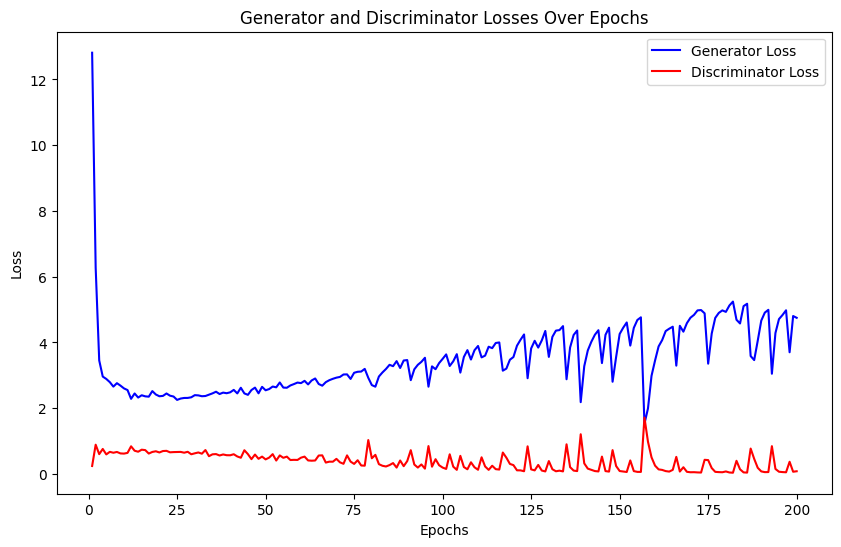

In [17]:
import time
import matplotlib.pyplot as plt

# Assuming the previous cell has set up the necessary variables like batch_size, epochs, etc.

# Initialize lists to store losses for plotting
gen_losses = []
disc_losses = []

for epoch in range(epochs):
    epoch_start_time = time.time()  # Start time for the epoch
    print(f"Epoch {epoch + 1}/{epochs}...")
    
    # Track the average losses for this epoch
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    
    for image_batch in train_dataset:
        step_start_time = time.time()  # Start time for the step
        
        # Run a training step and get the losses
        gen_loss, disc_loss = train_step(image_batch)
        
        epoch_gen_loss += gen_loss
        epoch_disc_loss += disc_loss
        
        step_end_time = time.time()  # End time for the step
        step_time = step_end_time - step_start_time
        
        # Print the loss and time for each step (optional)
        #print(f"Step Time: {step_time:.2f}s - Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
    
    # Average losses for the epoch
    avg_gen_loss = epoch_gen_loss / len(train_dataset)
    avg_disc_loss = epoch_disc_loss / len(train_dataset)
    
    # Store losses for plotting
    gen_losses.append(avg_gen_loss)
    disc_losses.append(avg_disc_loss)
    
    epoch_end_time = time.time()  # End time for the epoch
    epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch + 1} completed in {epoch_time:.2f}s")
    print(f"Average Generator Loss: {avg_gen_loss:.4f}, Average Discriminator Loss: {avg_disc_loss:.4f}\n")

# Plotting the losses after training is complete
plt.figure(figsize=(10, 6))

# Plot the generator and discriminator losses
plt.plot(range(1, epochs + 1), gen_losses, label="Generator Loss", color="blue")
plt.plot(range(1, epochs + 1), disc_losses, label="Discriminator Loss", color="red")

# Adding labels and title
plt.title("Generator and Discriminator Losses Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Show the plot
plt.show()


In [18]:
num_samples = 9
sample_noise = tf.random.normal([num_samples, latent_size])
sample_images = generator(sample_noise)
sample_images = 0.5 * sample_images + 0.5  # Denormalize
sample_images = np.clip(sample_images, 0, 1)  # Clip values to [0, 1]

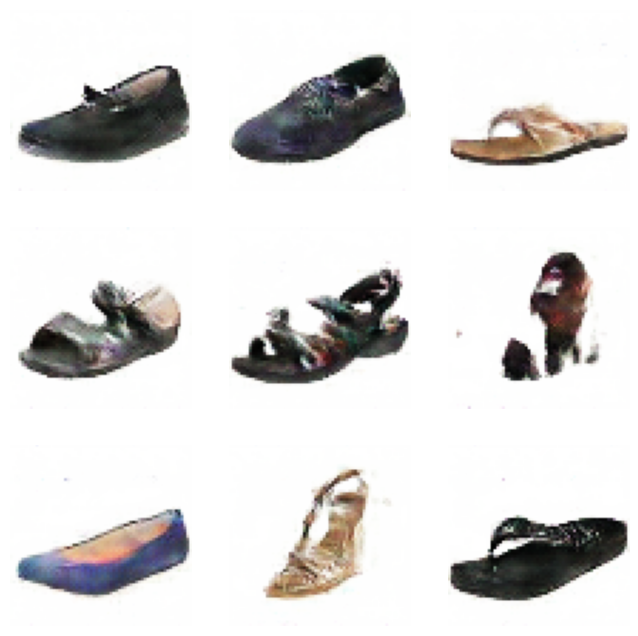

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_samples):
    axs[i // 3, i % 3].imshow(sample_images[i])
    axs[i // 3, i % 3].axis('off')
plt.show()